In [1]:
DEV = True

In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)

project_path = 'C:/Users/' + getpass.getuser() + 'Desktop/10_Thesis/cycle_prediction/'
project_exist = os.path.exists(project_path)
if project_exist and DEV:
    sys.path.insert(0, project_path)
    print('development mode')
else:
    print('user mode')
    
import cycle_prediction
print(cycle_prediction.__version__)
from cycle_prediction.t2e import t2e
from cycle_prediction.weibull_utils import plot_top_predictions

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
%load_ext autoreload
%autoreload 2

user mode
1.2.0


Using TensorFlow backend.


In [3]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13/'

flist = os.listdir(path)
dfs = pd.DataFrame()

for f in flist:
    df = pd.read_csv(path + f, delimiter=';')
    
    if 'incidents.csv' in f:
        df['type'] = 'incident'
    elif 'problems.csv' in f:
        df['type'] = 'problem'    
    dfs = pd.concat([dfs, df], axis=0)
    
print(dfs.shape)
print(dfs[dfs.columns[0]].nunique())
dfs.tail(2)

(74544, 17)
9395


,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,concept:name,impact,lifecycle:transition,org:group,org:role,organization country,organization involved,product,resource country,type,oranization country
2349,1-759318221,Accepted-In Progress,Ian,2012/06/15 12:17:18.000,Variant 3,3,Accepted,Medium,In Progress,Org line A2,A2_1,NaN,NaN,PROD236,United Kingdom,problem,gb
2350,1-759318221,Accepted-Assigned,Ian,2012/06/15 12:19:56.000,Variant 3,3,Accepted,Medium,Assigned,Org line A2,A2_1,NaN,NaN,PROD236,United Kingdom,problem,gb


In [8]:
dfs = dfs.loc[:, ['Case ID','Activity','Complete Timestamp','impact', 'type']]
dfs['Complete Timestamp'] = pd.to_datetime(dfs['Complete Timestamp'])
dfs.head()

,Case ID,Activity,Complete Timestamp,impact,type
0,1-109135791,Queued-Awaiting Assignment,2006-01-11 15:49:42,High,problem
1,1-109135791,Accepted-In Progress,2012-03-15 11:53:52,High,problem
2,1-109135791,Accepted-Assigned,2012-03-15 11:56:17,High,problem
3,1-109135791,Accepted-In Progress,2012-03-15 12:09:05,High,problem
4,1-109135791,Completed-Closed,2012-03-15 12:11:33,High,problem


In [32]:
def duration(df):
    return (df['Complete Timestamp'].max() - df['Complete Timestamp'].min()).total_seconds()/86400

<AxesSubplot:xlabel='duration', ylabel='type'>

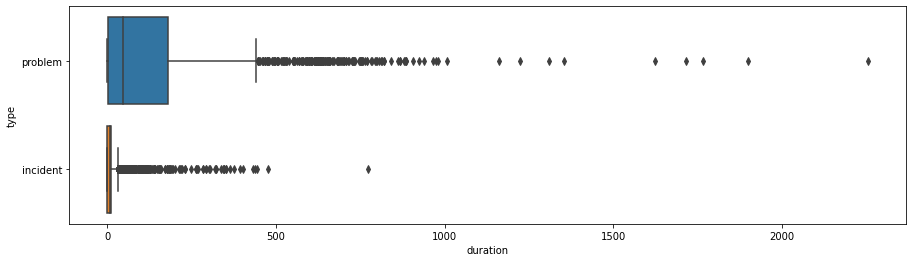

In [52]:
tmp = pd.DataFrame(dfs.groupby('Case ID').apply(lambda x: [duration(x), x['type'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','type'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['type'], orient='h')

<AxesSubplot:xlabel='duration', ylabel='impact'>

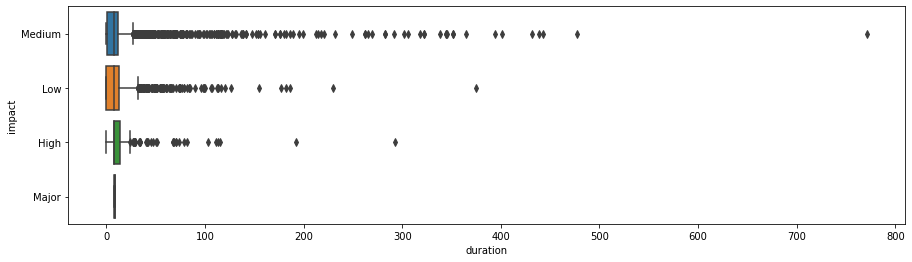

In [53]:
tmp = dfs.loc[dfs['type'] == 'incident']
tmp = pd.DataFrame(tmp.groupby('Case ID').apply(lambda x: [duration(x), x['impact'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','impact'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['impact'], orient='h')

<AxesSubplot:xlabel='duration', ylabel='impact'>

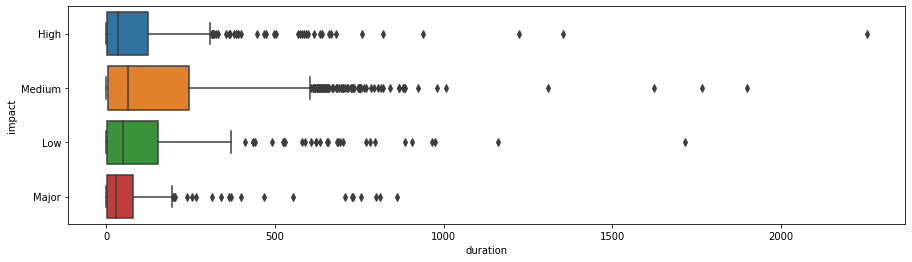

In [54]:
tmp = dfs.loc[dfs['type'] == 'problem']
tmp = pd.DataFrame(tmp.groupby('Case ID').apply(lambda x: [duration(x), x['impact'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','impact'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['impact'], orient='h')

In [55]:
# for col in dfs.columns[2:]:
#     try:
#         plt.figure()
#         dfs[col] = dfs[col].fillna('Unknown')
#         x, h = np.unique(dfs[col],return_counts=True)
#         if len(x) > 40:
#             print(col, len(x))
#             continue
#         plt.bar(x= x, height=h)
#         plt.xticks(rotation=45, ha='right')
#         nupc = max(dfs.groupby([dfs.columns[0]]).nunique()[col].unique())
#         plt.title(col + '  nunique: ' + str(dfs[col].nunique()) + '  per case: ' + str(nupc))
#         plt.show()
#     except:
#         print(col)
#         pass

In [3]:
path = '../data/'

a = os.path.join(path,'helpdesk.csv')
a = pd.read_csv(a)
b = os.path.join(path,'bpi_12_w.csv')
b = pd.read_csv(b)
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
c = pd.read_csv(c)
d = os.path.join(path,'env_permit.csv')
d = pd.read_csv(d)

df_name = {
    'a':'helpdesk',
    'b':'bpi_12_w',
    'c':'bpi_12_w_no_repeat',
    'd':'env_permit'
}

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

In [4]:
dataset='b'
res='d'
censored=True
cen_per=0.5
fit_type:'t2e'
transform = False
prefix=8
##########################################################
print("\ndataset:", dataset, "\tprefix:", prefix)

t2e_obj = t2e(df_dict[dataset],
              prefix = prefix,
              resolution = res,
              censored = censored,
              cen_prc = cen_per,
              fit_type = 't2e',
              transform = transform
             )
t2e_obj.preprocess_dev()
X_train, X_test, X_val, y_train, y_test, y_val, len_train, len_val, len_test = t2e_obj.smart_split(train_prc = 0.7,
                                                                                                     val_prc = 0.45,
                                                                                                      scaling=True)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)


dataset: b 	prefix: 8
all cases 3353
first 10 censored cases [178269 188164 182296 193177 206147 212280 176515 175192 188554 210008]
	Total Observed: 1677
	Training data Observed: 646
	Training data Censored: 1676
	Training data to use: 2322
	Validation data: 527
	Testing data   : 504
(2322, 8, 8) (504, 8, 8) (527, 8, 8) (2322, 2) (504, 2) (527, 2)


In [5]:
# if res == 'd':
#     bins = np.arange(0,y_train.max()+1, 1)
# elif res == 'h':
#     bins = np.arange(0,y_train.max()+24, 24)
# elif res == 's':
#     bins = np.arange(0,y_train.max()+86400, 86400)
    
# plt.figure(figsize=(6,4))
# plt.hist(y_train[:,0], bins = bins,label="Train");
# # plt.hist(y_val[:,0], bins = bins,label="Val");
# plt.hist(y_test[:,0], bins = bins, label="Test", color='lightgreen');
# plt.xlabel('Remaining time (T) in seconds')
# plt.ylabel('Occurences')
# plt.title('Train/Test label distribution')
# plt.legend()
# plt.show()

In [6]:
# root = 3
# root = 1/root
# power = 1/root
# print(root, power)

# plt.figure(figsize=(6,4))
# y_conv = (y_train[:,0]**root)

# plt.hist(y_conv, bins = 120,label="Train", alpha =1);

# y_conv = (y_test[:,0]**root)
# # y_conv = (np.log(y_test[:,0]))
# plt.hist(y_conv, bins = 120,label="Test", alpha=1, color='lightgreen');

# plt.xlabel('Remaining time (T) in seconds')
# plt.ylabel('Occurences')
# plt.title('Train/Test label distribution')
# plt.legend()
# plt.show()

In [7]:
print("Layer size:",8, end = " ..... ")
t2e_obj.fit(X_train, y_train, X_val, y_val,size=8, vb = True)
print("Done")
print("Training accomplished in", t2e_obj.fit_time, "seconds")
try:
    test_result_df, mae, accuracy = t2e_obj.evaluate(X_test,y_test)
    print('power:', t2e_obj.power)
    print(len(test_result_df['T_pred'].unique()), 'unique predictions')
    print(np.round(mae,3), 'mae')
except:
    print('evaluation failed')

Layer size: 8 ..... 

Epoch 1/500
18/19 [===========================>..] - ETA: 0s - loss: 1.5314
Epoch 00001: val_loss improved from inf to 5.19942, saving model to output/best_model.h5
19/19 [==============================] - 2s 89ms/step - loss: 1.6672 - val_loss: 5.1994
Epoch 2/500
18/19 [===========================>..] - ETA: 0s - loss: 1.3078
Epoch 00002: val_loss improved from 5.19942 to 5.19424, saving model to output/best_model.h5
19/19 [==============================] - 2s 116ms/step - loss: 1.4194 - val_loss: 5.1942
Epoch 3/500
18/19 [===========================>..] - ETA: 0s - loss: 1.1853
Epoch 00003: val_loss improved from 5.19424 to 5.13516, saving model to output/best_model.h5
19/19 [==============================] - 2s 102ms/step - loss: 1.3159 - val_loss: 5.1352
Epoch 4/500
18/19 [===========================>..] - ETA: 0s - loss: 1.1347
Epoch 00004: val_loss improved from 5.13516 to 4.94714, saving model to output/best_model.h5
19/19 [==============================] -

Epoch 35/500
18/19 [===========================>..] - ETA: 0s - loss: 1.0368
Epoch 00035: val_loss did not improve from 3.80065
19/19 [==============================] - 2s 85ms/step - loss: 1.0981 - val_loss: 3.8536
Epoch 36/500
18/19 [===========================>..] - ETA: 0s - loss: 1.0298
Epoch 00036: val_loss did not improve from 3.80065
19/19 [==============================] - 2s 84ms/step - loss: 1.0934 - val_loss: 3.8483
Epoch 37/500
18/19 [===========================>..] - ETA: 0s - loss: 1.0263
Epoch 00037: val_loss did not improve from 3.80065
19/19 [==============================] - 2s 86ms/step - loss: 1.0918 - val_loss: 3.8431
Epoch 38/500
18/19 [===========================>..] - ETA: 0s - loss: 1.0192
Epoch 00038: val_loss did not improve from 3.80065
19/19 [==============================] - 2s 88ms/step - loss: 1.0876 - val_loss: 3.8652
Epoch 39/500
18/19 [===========================>..] - ETA: 0s - loss: 1.0294
Epoch 00039: val_loss did not improve from 3.80065
19/19 [=

In [12]:
y_pred = t2e_obj.predict(X_test)
test_results_df, mae = t2e_obj.evaluate(X_test,y_test)

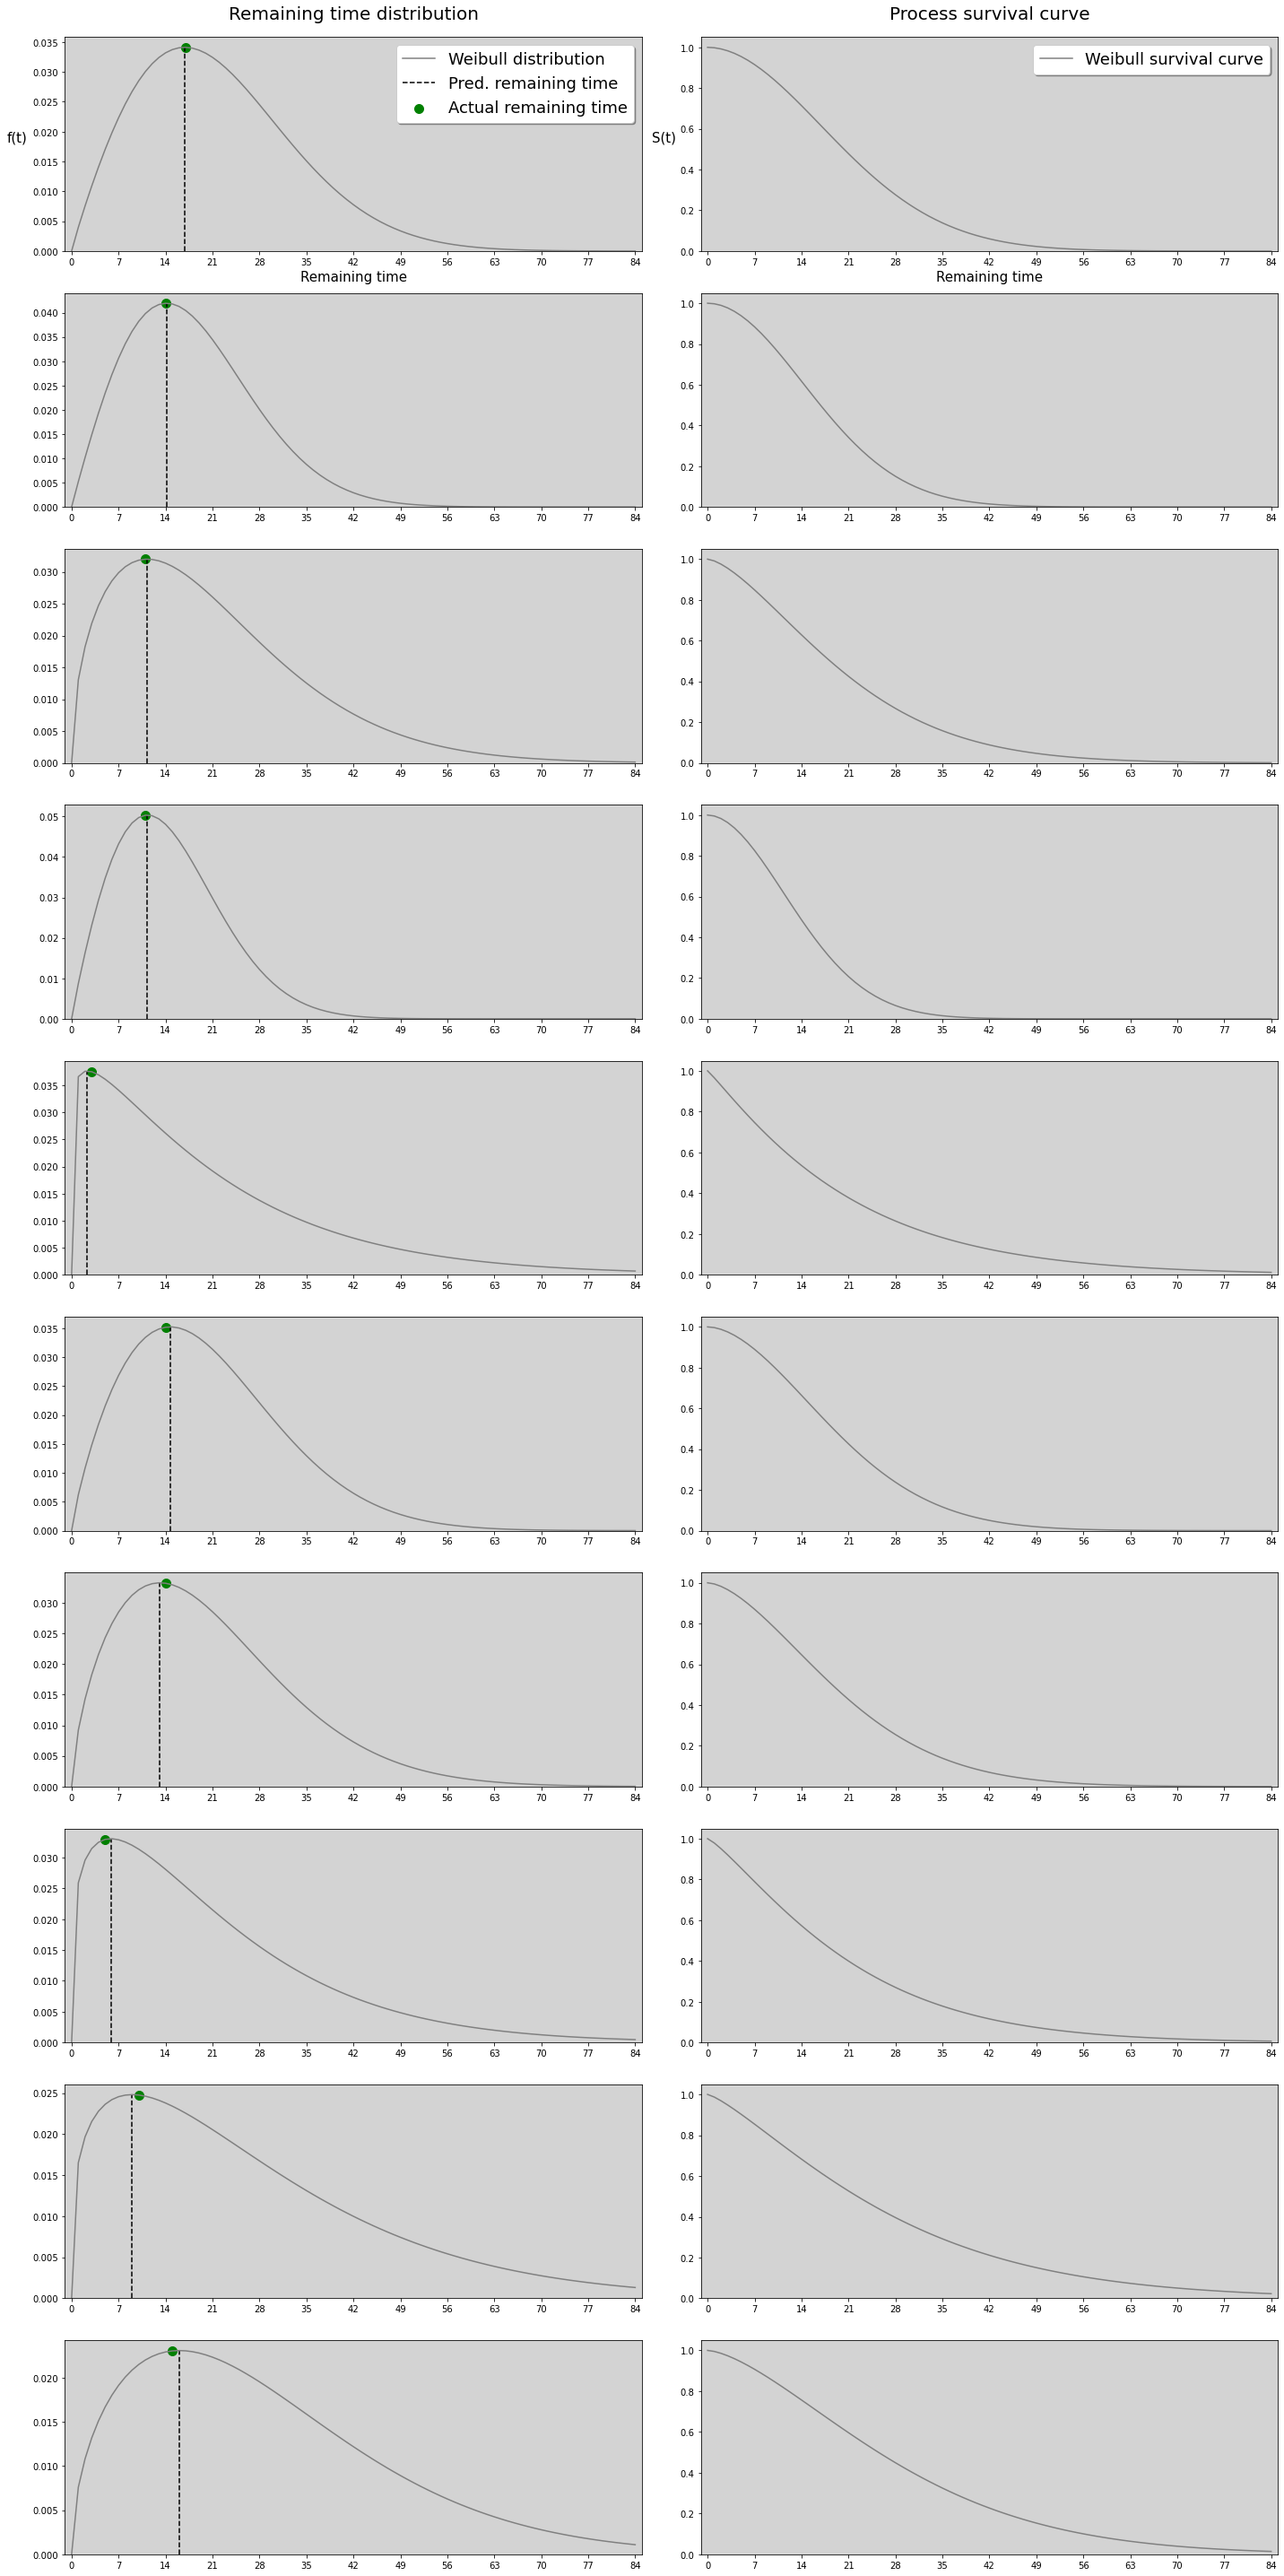

In [44]:
plot_top_predictions(test_results_df,lim=10)